# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [1]:
from tqdm import tnrange, tqdm_notebook, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

%matplotlib inline

## Input data

In [2]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
('Distance matrix:\n', array([[    0.        ,   666.10809934,   281.11385594, ...,
          217.08293346,   789.38267019,  1220.46097848],
       [  666.10809934,     0.        ,   649.32657423, ...,
          596.25917184,  1421.55724471,  1716.04924172],
       [  281.11385594,   649.32657423,     0.        , ...,
          463.24939288,   995.3140208 ,  1483.59361012],
       ..., 
       [  217.08293346,   596.25917184,   463.24939288, ...,
            0.        ,   829.60834133,  1150.76061803],
       [  789.38267019,  1421.55724471,   995.3140208 , ...,
          829.60834133,     0.        ,   624.81997407],
       [ 1220.46097848,  1716.04924172,  1483.59361012, ...,
         1150.76061803,   624.81997407,     0.        ]]))
('Optimal solution:\n', [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21])


## Objective function

In [3]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [30]:
tsp_objective_function(p)

7544.3659019040861

## SGA

In [4]:
def PMX(ind1, ind2):

    size = n
    p1, p2 = np.zeros(size, dtype='int'), np.zeros(size, dtype='int')

    # Initialize the position of each indices in the individuals
    for i in xrange(size):
        p1[ind1[i]] = i
        p2[ind2[i]] = i
    # Choose crossover points
    cxpoint1 = np.random.randint(0, size)
    cxpoint2 = np.random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    
    # Apply crossover between cx points
    for i in xrange(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = ind1[i]
        temp2 = ind2[i]
        # Swap the matched value
        ind1[i], ind1[p1[temp2]] = temp2, temp1
        ind2[i], ind2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    return ind1, ind2

In [5]:
def PPX(ind1, ind2):
    choices = np.random.randint(2, size= n)
    used = set()
    res1 = np.zeros(n)
    i1, i2 = 0,0
    for i in xrange(n):
        if choices[i] == 0:
            while ind1[i1] in used:
                i1 += 1
            used.add(ind1[i1])
            res1[i] = ind1[i1]
        else:
            while ind2[i2] in used:
                i2 += 1
            used.add(ind2[i2])
            res1[i] = ind2[i2]
        
    used = set()
    res2 = np.zeros(n)
    i1, i2 = 0,0
    choices = 1-choices
    for i in xrange(n):
        if choices[i] == 0:
            while ind1[i1] in used:
                i1 += 1
            used.add(ind1[i1])
            res2[i] = ind1[i1]
        else:
            while ind2[i2] in used:
                i2 += 1
            used.add(ind2[i2])
            res2[i] = ind2[i2]
    return res1,res2

In [5]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [21]:
def best_neighbour_mutation(p):
    k = 1
    best_neighbour = p.copy()
    best_score = tsp_objective_function(best_neighbour)
    for perms in itertools.combinations(itertools.combinations(range(n), 2), k):
        current = p.copy()
        for i,j in perms:
            current[i], current[j] = current[j], current[i]
        current_score = tsp_objective_function(current)
        if current_score < best_score:
            best_neighbour = current.copy()
            best_score = current_score
    return best_neighbour, best_score

In [7]:
def iterative_search(p):
    n, sc = best_neighbour_mutation(p)
    while True:
        nn, nsc = best_neighbour_mutation(n)
        if nsc == sc:
            break
        n, sc = nn, nsc
        print sc
    return n, sc

In [29]:
iterative_search(np.array(range(52)))

16874.4112231


15398.7331611


14280.8886748


13498.0587496


12937.8832738


12495.0616927


12176.7275333


11927.6385045


11753.1082869


11583.6669543


11455.6752121


11367.7311391


11297.3102007


11235.0667161


10947.600227


10832.4239746


10789.8218487


10724.3995476


10680.3829378


10639.7041512


10600.9460657


10589.0836039


10569.2892602


10538.5300994


10523.438919


10514.2759784


10473.3696721


10378.3276889


10352.9279995


10010.9610452


9926.09288306


9898.08542665


9841.14816885


9712.01790359


9491.10820762


9352.36427133


9277.57707185


9213.49807236


9178.89097802


9153.73141519


8924.10989947


8869.94329574


8747.46108616


8696.97812223


8653.90111664


8531.12069734


In [25]:
tsp_objective_function(best_neighbour_mutation(np.array(range(52))))

18970.734093407555

In [12]:
def SGA(
    population_size = 500,
    crossover_probability = 0.95,
    mutation_probability = 0.25,
    number_of_iterations = 250,
    crossover_operator = PMX,
    mutation_operator = reverse_sequence_mutation):
    
    chromosome_length = n
    number_of_offspring = population_size
    
    result = np.zeros((number_of_iterations, 6))

    time0 = time.time()
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in xrange(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in xrange(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :])

    for t in tqdm_notebook(xrange(number_of_iterations), desc='current run', leave=False):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = crossover_operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation_operator(children_population[i, :])
            if np.random.random() < mutation_probability:
                children_population[i, :] = best_neighbour_mutation(children_population[i, :])[0]

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
        result[t, :] = (
            t,
            time.time() - time0, 
            objective_values.min(), 
            objective_values.mean(), 
            objective_values.max(), 
            objective_values.std(),
        )
    return result

In [8]:
def multi_run(number_of_runs,
             mutation,
             crossover,
             iterations,
             step=None):
    min_values = np.zeros(number_of_runs)
    for i in tqdm_notebook(xrange(number_of_runs), desc='general progress'):
        result = SGA(number_of_iterations=iterations, mutation_operator=mutation, crossover_operator = crossover)
        print('%4d %14.8f %12.8f %12.8f %12.8f %12.8f' % tuple(result[iterations - 1,:]))
        min_values[i] = result[iterations - 1, 2]
    
    plt.figure(figsize=(15,8))
    plt.hist(min_values)
    plt.show()

In [14]:
res = SGA(number_of_iterations = 250, population_size = 500)

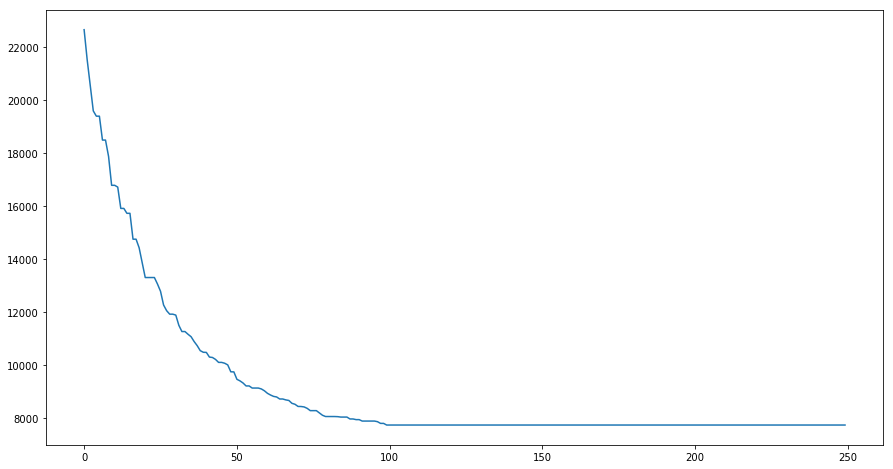

In [16]:
plt.figure(figsize=(15,8))
plt.plot(res[:, 2])
plt.show()

In [23]:
res[:, 2].min()

7735.7983852176776

In [22]:
SGA(mutation_probability=0.05)
plt.figure(figsize=(15,8))
plt.plot(res[:, 2])
plt.show()

array([[  0.00000000e+00,   6.20393038e-01,   2.33344425e+04,
          2.82453996e+04,   2.96659586e+04,   1.07959203e+03],
       [  1.00000000e+00,   1.31440401e+00,   2.18182283e+04,
          2.73129989e+04,   2.85152840e+04,   9.96131288e+02],
       [  2.00000000e+00,   2.00946283e+00,   2.18182283e+04,
          2.65635203e+04,   2.76748773e+04,   9.28333839e+02],
       ..., 
       [  2.47000000e+02,   1.80333289e+02,   8.22009228e+03,
          8.22009228e+03,   8.22009228e+03,   1.81898940e-12],
       [  2.48000000e+02,   1.81106571e+02,   8.22009228e+03,
          8.22009228e+03,   8.22009228e+03,   1.81898940e-12],
       [  2.49000000e+02,   1.82099954e+02,   8.22009228e+03,
          8.22009228e+03,   8.22009228e+03,   1.81898940e-12]])